In [ ]:
!pip install -q torch==1.9.0


ERROR: Could not find a version that satisfies the requirement torch==1.9.0 (from versions: 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.9.0

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [ ]:
import torch
torch.__version__

'1.9.0'

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

**DATA PREP**

In [ ]:
columns_name=['user_id','item_id','rating','timestamp']
#df = pd.read_csv("/Users/davis/Desktop/ml-100k/u.data",sep="\t",names=columns_name)
df = pd.read_csv("/Users/davis/Desktop/movie/u.data",sep="\t",names=columns_name)
print(len(df))
display(df.head(5))
#df_sorted = df.sort_values('user_id')
#print(len(df_sorted))
#display(df_sorted.head(5))

100003


,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [ ]:
movie_titles = pd.read_csv("/Users/davis/Desktop/movie/Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [ ]:
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [ ]:
df = df[df['rating']>=3]
print(len(df))

print("Rating Distribution")
df.groupby(['rating'])['rating'].count()


82522
Rating Distribution


rating
3    27145
4    34174
5    21203
Name: rating, dtype: int64

**SPLIT DATA INTO TRAIN AND TEST**

In [ ]:
train, test = train_test_split(df.values, test_size=0.2, random_state = 16)
# random_state = 16
#20 percent of data will be use to test
train = pd.DataFrame(train, columns = df.columns)
print("Train Size  : ", len(train))

test = pd.DataFrame(test, columns = df.columns)
print("Test Size : ", len (test))

print('all data : ',len(train)+len(test))

Train Size  :  74269
Test Size :  8253
all data :  82522


**Label encoding** Label Encoding is a technique that is used to convert categorical columns into numerical ones so that they can be fitted by machine learning models which only take numerical data.

In [ ]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train['user_id_idx'] = le_user.fit_transform(train['user_id'].values)
train['item_id_idx'] = le_item.fit_transform(train['item_id'].values)

In [ ]:
train_user_ids = train['user_id'].unique()
train_item_ids = train['item_id'].unique()

print(f"len train_user_ids : {len(train_user_ids)}, len train_item_ids : {len(train_item_ids)}")

test = test[(test['user_id'].isin(train_user_ids)) & (test['item_id'].isin(train_item_ids))]
print(len(test))

len train_user_ids : 944, len train_item_ids : 1549
8227


In [ ]:
test['user_id_idx'] = le_user.transform(test['user_id'].values)
test['item_id_idx'] = le_item.transform(test['item_id'].values)

In [ ]:
n_users = train['user_id_idx'].nunique()
n_items = train['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  944
Number of unique Items :  1549


In [ ]:
latent_dim = 64 #length of the user/item embedding.
n_layers = 3  # the number of times we want to propagate our initial user/item embedding through the graph

In [ ]:
def convert_to_sparse_tensor(dok_mtrx):

    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)
    values = dok_mtrx_coo.data
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

In [ ]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):

    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight = user_Embed_wts)
    item_Embedding = nn.Embedding(item_Embed_wts.size()[0], item_Embed_wts.size()[1], _weight = item_Embed_wts)

    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
    R[train_data['user_id_idx'], train_data['item_id_idx']] = 1.0

    R_tensor = convert_to_sparse_tensor(R)
    R_tensor_dense = R_tensor.to_dense()

    R_tensor_dense = R_tensor_dense*(-np.inf)
    R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0)

    relevance_score = relevance_score+R_tensor_dense

    topk_relevance_score = torch.topk(relevance_score, K).values
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])

    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index

    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]


    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    def get_hit_list(item_id_idx, top_rlvnt_itm):
        return [1 if x in set(item_id_idx) else 0 for x in top_rlvnt_itm ]

    metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['item_id_idx'], x['top_rlvnt_itm']), axis = 1)

    def get_dcg_idcg(item_id_idx, hit_list):
        idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(item_id_idx),len(hit_list)))])
        dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
        return dcg/idcg

    def get_cumsum(hit_list):
        return np.cumsum(hit_list)

    def get_map(item_id_idx, hit_list, hit_list_cumsum):
        return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(item_id_idx)

    metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['item_id_idx'], x['hit_list']), axis = 1)
    metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['item_id_idx'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean()

**LightGCN Model**

In [ ]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_items, n_layers, latent_dim):
        super(LightGCN, self).__init__()
        self.data = data
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        self.E0 = nn.Embedding(self.n_users + self.n_items, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def get_A_tilda(self):
        R = sp.dok_matrix((self.n_users, self.n_items), dtype = np.float32)
        R[self.data['user_id_idx'], self.data['item_id_idx']] = 1.0

        adj_mat = sp.dok_matrix(
                (self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32
            )
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: n_users, n_users :] = R
        adj_mat[n_users :, : n_users] = R.T
        adj_mat = adj_mat.todok()

        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)

        # Below Code is toconvert the dok_matrix to sparse tensor.

        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor

    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [n_users, n_items])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [n_users, n_items])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed

    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0

# The forward method takes the user, positive item, and negative item indices as inputs and returns the corresponding embeddings.

In [ ]:
lightGCN = LightGCN(train, n_users, n_items, n_layers, latent_dim)

In [ ]:
print("Size of Learnable Embedding : ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([2493, 64])


# The bpr_loss function calculates the Bayesian Personalized Ranking (BPR) loss given the user embeddings, positive item embeddings, and negative item embeddings.


In [ ]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):

    reg_loss = (1/2)*(userEmb0.norm().pow(2) +
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)

    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))

    return loss, reg_loss

#The data_loader function generates mini-batches of user, positive item, and negative item indices for training.

In [ ]:
def data_loader(data, batch_size, n_usr, n_itm):

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()

    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')

    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values

    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)

In [ ]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.005)

In [ ]:
EPOCHS = 30
BATCH_SIZE = 1024
DECAY = 0.0001
K = 10

In [ ]:
from tqdm import tqdm
import time

loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []
recall_list = []
precision_list = []
ndcg_list = []
map_list = []
train_time_list = []
eval_time_list = []

for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    n_batch = int(len(train) / BATCH_SIZE)
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
    best_ndcg = -1
    train_start_time = time.time()
    lightGCN.train()

    for batch_idx in range(n_batch):
        optimizer.zero_grad()
        users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)
        users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)
        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0)
        reg_loss = DECAY * reg_loss
        final_loss = mf_loss + reg_loss
        final_loss.backward()
        optimizer.step()
        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())

    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    lightGCN.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = lightGCN.propagate_through_layers()
        test_topK_recall, test_topK_precision, test_topK_ndcg, test_topK_map = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)

    if test_topK_ndcg > best_ndcg:
        best_ndcg = test_topK_ndcg
        torch.save(final_user_Embed, 'final_user_Embed.pt')
        torch.save(final_item_Embed, 'final_item_Embed.pt')
        torch.save(initial_user_Embed, 'initial_user_Embed.pt')
        torch.save(initial_item_Embed, 'initial_item_Embed.pt')

    eval_time = time.time() - train_end_time

    loss_list_epoch.append(round(np.mean(final_loss_list), 4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list), 4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list), 4))
    recall_list.append(round(test_topK_recall, 4))
    precision_list.append(round(test_topK_precision, 4))
    ndcg_list.append(round(test_topK_ndcg, 4))
    map_list.append(round(test_topK_map, 4))
    train_time_list.append(train_time)
    eval_time_list.append(eval_time)

    # Print loading time for the current epoch
    print(f"Epoch {epoch + 1} - Train Time: {train_time:.2f}s, Eval Time: {eval_time:.2f}s")


Epochs:   3%|█▏                                  | 1/30 [00:03<01:40,  3.48s/it]

Epoch 1 - Train Time: 3.32s, Eval Time: 0.16s


Epochs:   7%|██▍                                 | 2/30 [00:07<01:38,  3.53s/it]

Epoch 2 - Train Time: 3.40s, Eval Time: 0.16s


Epochs:  10%|███▌                                | 3/30 [00:10<01:34,  3.51s/it]

Epoch 3 - Train Time: 3.34s, Eval Time: 0.15s


Epochs:  13%|████▊                               | 4/30 [00:13<01:30,  3.49s/it]

Epoch 4 - Train Time: 3.30s, Eval Time: 0.15s


Epochs:  17%|██████                              | 5/30 [00:17<01:27,  3.49s/it]

Epoch 5 - Train Time: 3.33s, Eval Time: 0.15s


Epochs:  20%|███████▏                            | 6/30 [00:20<01:23,  3.47s/it]

Epoch 6 - Train Time: 3.29s, Eval Time: 0.15s


Epochs:  23%|████████▍                           | 7/30 [00:24<01:20,  3.48s/it]

Epoch 7 - Train Time: 3.36s, Eval Time: 0.15s


Epochs:  27%|█████████▌                          | 8/30 [00:27<01:16,  3.47s/it]

Epoch 8 - Train Time: 3.30s, Eval Time: 0.15s


Epochs:  30%|██████████▊                         | 9/30 [00:31<01:13,  3.50s/it]

Epoch 9 - Train Time: 3.41s, Eval Time: 0.15s


Epochs:  33%|███████████▋                       | 10/30 [00:34<01:09,  3.49s/it]

Epoch 10 - Train Time: 3.30s, Eval Time: 0.15s


Epochs:  37%|████████████▊                      | 11/30 [00:38<01:06,  3.49s/it]

Epoch 11 - Train Time: 3.32s, Eval Time: 0.16s


Epochs:  40%|██████████████                     | 12/30 [00:41<01:02,  3.49s/it]

Epoch 12 - Train Time: 3.34s, Eval Time: 0.15s


Epochs:  43%|███████████████▏                   | 13/30 [00:45<00:59,  3.48s/it]

Epoch 13 - Train Time: 3.30s, Eval Time: 0.15s


Epochs:  47%|████████████████▎                  | 14/30 [00:48<00:55,  3.47s/it]

Epoch 14 - Train Time: 3.31s, Eval Time: 0.15s


Epochs:  50%|█████████████████▌                 | 15/30 [00:52<00:52,  3.48s/it]

Epoch 15 - Train Time: 3.33s, Eval Time: 0.15s


Epochs:  53%|██████████████████▋                | 16/30 [00:55<00:48,  3.49s/it]

Epoch 16 - Train Time: 3.38s, Eval Time: 0.15s


Epochs:  57%|███████████████████▊               | 17/30 [00:59<00:45,  3.48s/it]

Epoch 17 - Train Time: 3.30s, Eval Time: 0.15s


Epochs:  60%|█████████████████████              | 18/30 [01:02<00:41,  3.47s/it]

Epoch 18 - Train Time: 3.31s, Eval Time: 0.15s


Epochs:  63%|██████████████████████▏            | 19/30 [01:06<00:38,  3.47s/it]

Epoch 19 - Train Time: 3.30s, Eval Time: 0.15s


Epochs:  67%|███████████████████████▎           | 20/30 [01:09<00:34,  3.47s/it]

Epoch 20 - Train Time: 3.31s, Eval Time: 0.15s


Epochs:  70%|████████████████████████▌          | 21/30 [01:13<00:31,  3.49s/it]

Epoch 21 - Train Time: 3.40s, Eval Time: 0.15s


Epochs:  73%|█████████████████████████▋         | 22/30 [01:16<00:27,  3.48s/it]

Epoch 22 - Train Time: 3.30s, Eval Time: 0.15s


Epochs:  77%|██████████████████████████▊        | 23/30 [01:20<00:24,  3.47s/it]

Epoch 23 - Train Time: 3.30s, Eval Time: 0.15s


Epochs:  80%|████████████████████████████       | 24/30 [01:23<00:20,  3.47s/it]

Epoch 24 - Train Time: 3.30s, Eval Time: 0.15s


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:27<00:17,  3.48s/it]

Epoch 25 - Train Time: 3.36s, Eval Time: 0.15s


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:30<00:13,  3.47s/it]

Epoch 26 - Train Time: 3.30s, Eval Time: 0.15s


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:33<00:10,  3.47s/it]

Epoch 27 - Train Time: 3.30s, Eval Time: 0.15s


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:37<00:06,  3.46s/it]

Epoch 28 - Train Time: 3.30s, Eval Time: 0.15s


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:40<00:03,  3.46s/it]

Epoch 29 - Train Time: 3.30s, Eval Time: 0.15s


Epochs: 100%|███████████████████████████████████| 30/30 [01:44<00:00,  3.48s/it]

Epoch 30 - Train Time: 3.43s, Eval Time: 0.15s


In [ ]:
epoch_list = [(i+1) for i in range(EPOCHS)]


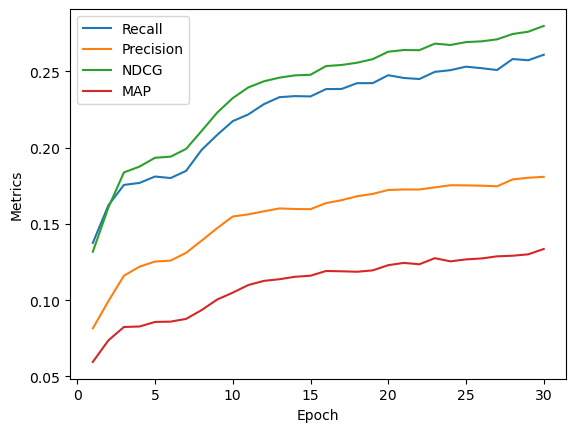

In [ ]:
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()


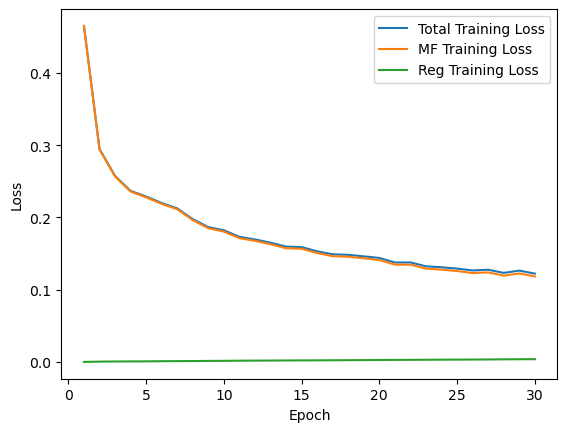

In [ ]:

plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
print("Averge time taken to train an epoch -> ", round(np.mean(train_time_list),2), " seconds")
print("Averge time taken to eval an epoch -> ", round(np.mean(eval_time_list),2), " seconds")

Averge time taken to train an epoch ->  3.33  seconds
Averge time taken to eval an epoch ->  0.15  seconds


In [ ]:
print("Last Epoch's Test Data Recall -> ", recall_list[-1])
print("Last Epoch's Test Data Precision -> ", precision_list[-1])
print("Last Epoch's Test Data NDCG -> ", ndcg_list[-1])
print("Last Epoch's Test Data MAP -> ", map_list[-1])

print("Last Epoch's Train Data Loss -> ", loss_list_epoch[-1])

Last Epoch's Test Data Recall ->  0.2608
Last Epoch's Test Data Precision ->  0.1808
Last Epoch's Test Data NDCG ->  0.2797
Last Epoch's Test Data MAP ->  0.1335
Last Epoch's Train Data Loss ->  0.1223


NDCG is a measure of the effectiveness of a ranking system, taking into account the position of relevant items in the ranked list.It is based on the idea that items that are higher in the ranking should be given more credit than items that are lower in the ranking


Mean Average Precision at K (MAP@K) is one of the most commonly used evaluation metrics for recommender systems and other ranking related classification tasks. Since this metric is a composition of different error metrics or layers, it may not be that easy to understand at first glance.

precision can be seen as a measure of quality. High precision means that our model returns more relevant than irrelevant results or recommendations.

# The similarity between the target item and all other items is calculated using dot product similarity.
# The items are sorted based on similarity scores.
# The top recommended movies are printed based on the sorted similarity scores.


In [ ]:
# Load the trained model embeddings
final_user_Embed = torch.load('final_user_Embed.pt')
final_item_Embed = torch.load('final_item_Embed.pt')

movie_id = 1

# Get the movie title for the watched movie
movie_title = movie_titles[movie_titles['item_id'] == movie_id]['title'].values[0]
print("Movie Title: ", movie_title)

target_item_embedding = final_item_Embed[movie_id]

# Calculate the similarity between the target item and all other items
similarity_scores = torch.matmul(final_item_Embed, target_item_embedding)
sorted_indices = torch.argsort(similarity_scores, descending=True)

recommended_items = sorted_indices[:6]
print(recommended_items)

# Print the recommended movie titles
print(f"Recommended Movies After Watching {movie_title}:")
for item_id in recommended_items:
    if item_id in movie_titles['item_id'].values:
        movie_title = movie_titles[movie_titles['item_id'] == item_id]['title'].values[0]
        print(movie_title)
    else:
        print(f"Movie with item ID {item_id} not found in movie_titles DataFrame.")


Movie Title:  Toy Story (1995)
tensor([209, 171, 173,  49,  97, 203])
Recommended Movies After Watching Toy Story (1995):
Movie with item ID 209 not found in movie_titles DataFrame.
Movie with item ID 171 not found in movie_titles DataFrame.
Movie with item ID 173 not found in movie_titles DataFrame.
Movie with item ID 49 not found in movie_titles DataFrame.
Movie with item ID 97 not found in movie_titles DataFrame.
Movie with item ID 203 not found in movie_titles DataFrame.
